# Quantum oscillators: optimal SNAP gates
**Engineering fast, leakage-free gates in superconducting cavity-qubit systems**

BOULDER OPAL provides you with a flexible framework to optimize and simulate quantum systems with various levels of complexity. This application note demonstrates such flexibility by considering the optimization of a gate performed using multiple levels of a quantum oscillator coupled to a qubit. In particular, you’ll learn how to suppress leakage to neighboring energy levels in Selective Number-dependent Arbitrary Phase (SNAP) gates applied to a superconducting cavity coupled to a transmon qubit.

The high dimensionality of the Hilbert space of quantum oscillators can be viewed as a resource to encode and process quantum information. However, in some cases, this multiplicity of levels can be detrimental to gate performance as operations intended to occur in a particular subspace end up populating unwanted levels. In practice, long pulse durations are used to narrow the operation's spectral range and, consequently, prevent leakage to neighboring levels. Longer gates, however, expose the system to other limiting factors such as spontaneous decay and cavity losses. In this notebook, you'll have the opportunity to use BOULDER OPAL optimization tools to make SNAP gates faster while suppressing leakage at the same time.

The notebook contains two sections, as follows. In the first section, you'll look at the detrimental effects of leakage in standard implementations of SNAP gates built on slow control $\pi$ rotations. In the second section, you'll use BOULDER OPAL to generate fast SNAP gates using significantly higher Rabi rates, which optimally suppress leakage across a multitude of Fock states at once.

### Imports and initialization

In [1]:
# BOULDER OPAL
from qctrl import Qctrl

qctrl = Qctrl()

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from qctrlvisualizer import get_qctrl_style, plot_controls
from scipy.linalg import expm

plt.style.use(get_qctrl_style())

# System parameters
target_Fock_n = 1  # the Fock state that the SNAP gate is targeting
theta = np.pi / 2  # SNAP gate angle

chi = 2 * np.pi * 1.189e6  # rad.Hz,
K = 2 * np.pi * 4e3  # rad.Hz,
wt = -chi * target_Fock_n  # interaction picture
wc = 0  # interaction picture

# Helper functions
def simulate_unitaries(dimt, dimc, controls, sample_points):
    drive_control_segments = controls["$\gamma$"]

    gate_duration = np.sum([s["duration"] for s in drive_control_segments])
    sample_times = np.linspace(0, gate_duration, sample_points)

    # Set up operators
    a = np.diag(np.sqrt(np.arange(1, dimc)), k=1)
    b = np.diag(np.sqrt(np.arange(1, dimt)), k=1)

    Hosc = wc * np.kron(np.eye(dimt), np.dot(a.T, a)) + K / 2 * np.kron(
        np.eye(dimt), np.dot(np.dot(a.T, a.T), np.dot(a, a))
    )
    Htrans = wt * np.kron(np.dot(b.T, b), np.eye(dimc))
    Hint = chi * np.kron(np.dot(b.T, b), np.dot(a.T, a))
    control_T = np.kron(b.T, np.eye(dimc))

    # Set up Hamiltonian terms
    H_drive_term = qctrl.types.coherent_simulation.Drive(
        control=[
            qctrl.types.ComplexSegmentInput(duration=s["duration"], value=s["value"])
            for s in drive_control_segments
        ],
        operator=control_T / 2,
    )

    H_osc = qctrl.types.coherent_simulation.Drift(operator=Hosc)
    H_trans = qctrl.types.coherent_simulation.Drift(operator=Htrans)
    H_int = qctrl.types.coherent_simulation.Drift(operator=Hint)

    # Run a simulation with optimized values
    simulation_result = qctrl.functions.calculate_coherent_simulation(
        duration=gate_duration,
        sample_times=sample_times,
        drives=[H_drive_term],
        drifts=[H_osc, H_trans, H_int],
    )

    return simulation_result


def run_optimization(dimt, dimc, target, gate_duration, max_rabi_rate):
    # optimization parameters
    max_rabi_rate_T = max_rabi_rate
    # cutoff frequency for the sinc filter
    cutoff_frequency = max_rabi_rate
    # number of degrees of freedom per pulse for the optimizer
    number_of_optimizer_vars = 64
    # number of pulse segments
    number_of_segments = 256
    # number of optimization runs
    optimization_count = 20

    # Annihilation and creation operators for the transmon and cavity
    a = np.diag(np.sqrt(np.arange(1, dimc)), k=1)
    b = np.diag(np.sqrt(np.arange(1, dimt)), k=1)

    # Specify system Hamiltonians
    Hosc = wc * np.kron(np.eye(dimt), np.dot(a.T, a)) + K / 2 * np.kron(
        np.eye(dimt), np.dot(np.dot(a.T, a.T), np.dot(a, a))
    )
    Htrans = wt * np.kron(np.dot(b.T, b), np.eye(dimc))
    Hint = chi * np.kron(np.dot(b.T, b), np.dot(a.T, a))
    # Define drive control operators
    control_T = np.kron(b.T, np.eye(dimc))

    with qctrl.create_graph() as graph:

        # set up a sinc filter to bandlimit the pulses (if desired)
        sinc_filter = qctrl.operations.sinc_integral_function(cutoff_frequency)

        # set up optimizer variables for the i component of the transmon drive
        drive_iT_vars = qctrl.operations.bounded_optimization_variable(
            count=number_of_optimizer_vars,
            lower_bound=-max_rabi_rate_T,
            upper_bound=max_rabi_rate_T,
        )
        # build the pulse signal with segments based on the optimizer variables
        drive_iT_raw = qctrl.operations.pwc_signal(
            values=drive_iT_vars, duration=gate_duration
        )
        # apply the filter to the raw pulse
        drive_iT_filtered = qctrl.operations.convolve_pwc(
            pwc=drive_iT_raw, kernel_integral=sinc_filter
        )
        # discretize the filtered drive into the desired number of segments
        drive_iT_signal = qctrl.operations.discretize_stf(
            stf=drive_iT_filtered,
            duration=gate_duration,
            segments_count=number_of_segments,
        )

        # set up the q component of the drive in a similar way
        drive_qT_vars = qctrl.operations.bounded_optimization_variable(
            count=number_of_optimizer_vars,
            lower_bound=-max_rabi_rate_T,
            upper_bound=max_rabi_rate_T,
        )
        drive_qT_raw = qctrl.operations.pwc_signal(
            values=drive_qT_vars, duration=gate_duration
        )
        drive_qT_filtered = qctrl.operations.convolve_pwc(
            pwc=drive_qT_raw, kernel_integral=sinc_filter
        )
        drive_qT_signal = qctrl.operations.discretize_stf(
            stf=drive_qT_filtered,
            duration=gate_duration,
            segments_count=number_of_segments,
        )

        # combine the i and q components
        driveT_signal = qctrl.operations.pwc_signal(
            values=qctrl.operations.complex_value(
                drive_iT_signal.values, drive_qT_signal.values
            ),
            duration=gate_duration,
            name="$\gamma$",
        )

        # build the system Hamiltonian terms
        H_osc = qctrl.operations.constant_pwc_operator(
            operator=Hosc, duration=gate_duration
        )
        H_trans = qctrl.operations.constant_pwc_operator(
            operator=Htrans, duration=gate_duration
        )
        H_int = qctrl.operations.constant_pwc_operator(
            operator=Hint, duration=gate_duration
        )

        H_drive_T = qctrl.operations.pwc_operator_hermitian_part(
            qctrl.operations.pwc_operator(signal=driveT_signal, operator=control_T)
        )

        # construct the total Hamiltonian
        hamiltonian = qctrl.operations.pwc_sum([H_osc, H_trans, H_int, H_drive_T])
        noise_list = []

        # gate infidelity cost
        cost = qctrl.operations.infidelity_pwc(
            hamiltonian=hamiltonian,
            target_operator=qctrl.operations.target(target),
            noise_operators=noise_list,
            name="cost",
        )

    # run optimization
    return qctrl.functions.calculate_optimization(
        graph=graph,
        cost_node_name="cost",
        output_node_names=["$\gamma$"],
        optimization_count=optimization_count,
    )


def standard_SNAP_controls(rabi_rate, theta):
    segment_duration = np.pi / rabi_rate
    return {
        "$\\gamma$": [
            {"duration": segment_duration, "value": rabi_rate},
            {
                "duration": segment_duration,
                "value": np.exp(1j * np.pi - 1j * theta) * rabi_rate,
            },
        ],
    }


colors_standard = ["#64A0EB", "#D84144", "#32A857", "#A2A933"]
colors_qctrl = ["#64A0EB", "#680CE9", "#32A857", "#A2A933"]

# Data containers
controls = {}
simulation_results = {}

## Model of the oscillator-qubit system

The system consists of a superconducting transmon system coupled to a cavity in the dispersive limit, as given by the following Hamiltonian:

$$H = \omega_C a^\dagger a + \frac{K}{2} (a^\dagger)^2 a^2 + \omega_T b^\dagger b + \chi a^\dagger a b^\dagger b + \left(\gamma (t) b + H.c.\right), $$

where $\omega_C$ is the cavity transition frequency, $a$ is the annihilation operator of a cavity excitation, $b$ is the annihilation operator of the transmon system, $K$ is the Kerr coefficient, $\omega_T$ is the transmon frequency, $\chi$ is the dispersive shift and $\gamma(t)= I(t) + i Q(t)$ is the complex drive amplitude. The basis states in the Hilbert space will be denoted by $|i,j\rangle =|i\rangle_T \otimes |j\rangle_C$, for the transmon number state $|i\rangle_T$ and cavity number state $|j\rangle_C$. 

In the remainder of notebook, the transmon system will be operated as a qubit formed by the lowest two energy levels, while the cavity will be populated by the first $n_c$ Fock states. Note that in this configuration, the qubit will exhibit a spectrum of transition frequencies, set $\chi$ apart, each corresponding to a different excitation state of the cavity.

## Standard SNAP gate

The objective of a SNAP gate is to impart a phase of $\theta$ to a target Fock state $j$ of the cavity $|j\rangle_C \rightarrow e^{i\theta} |j\rangle_C $. The [standard implementation](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.137002) of SNAP gates consists of two control $\pi$ pulses applied on the transmon qubit based on a target Fock state of the cavity. The pulses are performed around different axes, offset apart by an angle $\theta$. By the end of the gate,the qubit makes a net $2\pi$ rotation, disentangling from the targeted Fock state while imparting the desired phase $\theta$ to it.

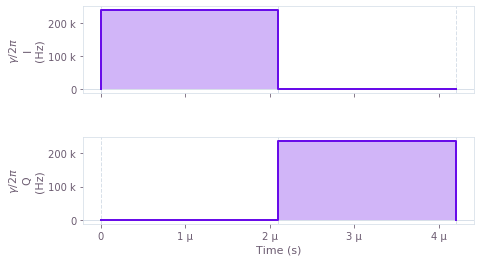

In [2]:
standard_SNAP_gate_rabi_rate = 0.2 * chi
controls["Standard"] = standard_SNAP_controls(standard_SNAP_gate_rabi_rate, theta)

plot_controls(plt.figure(), controls["Standard"], polar=False)

The plots display the drive pulses $\gamma(t)$ applied on the transmon qubit. Note that since the standard SNAP gates demand high spectral selectivity, the qubit Rabi rates need to be smaller than the the qubit-cavity coupling $|\gamma| < \chi$, making the gate relatively long, (for example see [Heeres at al.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.137002)). 

### Simulate the system evolution under the standard controls

You'll begin by simulating the evolution of the system. For this purpose, the first four states of the cavity ($n_c=4$) will be evenly populated while the qubit will be initialized in the ground state $| 0\rangle_T$, making the total  initial state: $(|0, 0\rangle + |0, 1\rangle + |0, 2\rangle + |0, 3\rangle)/\sqrt{4}$. 

You'll target the first Fock state $|1\rangle_C$ with the SNAP gate, evolving the initial state into $(|0, 0\rangle + e^{i\theta}|0, 1\rangle + |0, 2\rangle + |0, 3\rangle)/\sqrt(4)$, for the gate angle $\theta$, here chosen to be $\theta=\pi/2$.

In [3]:
# simulation parameters

sim_dimt = 2  # transmon dimensions
sim_dimc = 4  # cavity dimensions

# equal superposition as the initial state of the cavity
c_initial_state = np.full((sim_dimc), 1)
c_initial_state = c_initial_state / np.sqrt(
    np.abs(c_initial_state.dot(np.conj(c_initial_state)))
)
# qubit initialised into the ground state
t_initial_state = np.zeros(sim_dimt)
t_initial_state[0] = 1
# system initial state
initial_state = np.kron([t_initial_state], [c_initial_state])
# number of evolution samples
sample_points = 512

# simulate
simulation_results["Standard"] = simulate_unitaries(
    sim_dimt, sim_dimc, controls["Standard"], sample_points
)

100%|██████████| 100/100 [00:05<00:00, 16.93it/s]


To understand the evolution of the cavity states under the standard SNAP gate, it's instructive to plot both the probabilities and the phases of all the $|0,n\rangle$ states.

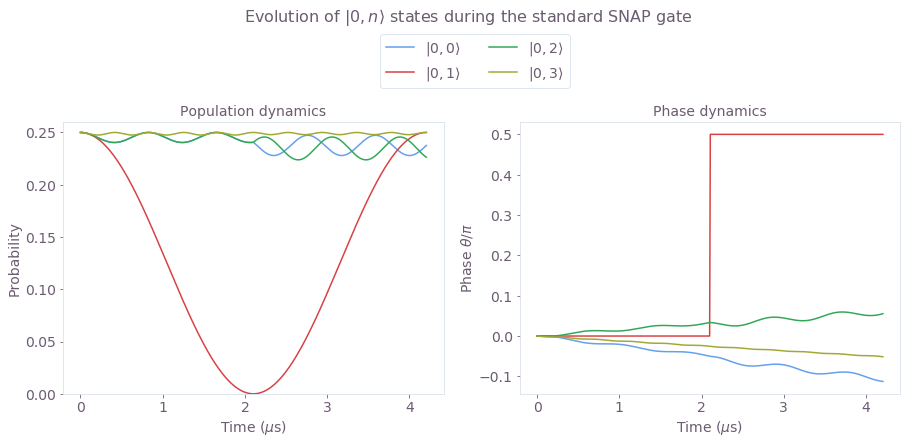

In [4]:
# Plot the state evolutions
simulation_result = simulation_results["Standard"].samples
sample_times = []
populations = []
phases = []
transmon_pops = []

for step in simulation_result:
    evolved_state = step.evolution_operator.dot(initial_state.T)
    sample_times.append(step.time)
    populations.append([])
    phases.append([])
    for n in range(sim_dimc):
        cavityn = np.zeros(sim_dimc)
        cavityn[n] = 1.0
        population = (
            np.abs(np.sum(np.kron(np.diag([1, 0]), [cavityn]).dot(evolved_state))) ** 2
        )
        populations[-1].append(population)
        phase = np.angle(
            np.sum(np.kron(np.diag([1.0, 0.0]), [cavityn]).dot(evolved_state))
        )
        phases[-1].append(phase)

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(3 * 5)
fig.suptitle(
    r"Evolution of $|0,n\rangle$ states during the standard SNAP gate",
    fontsize=16,
    y=1.2,
)
gs = gridspec.GridSpec(1, 2)
# plot probabilities
ax = fig.add_subplot(gs[0])
ax.set_xlabel(r"Time ($\mu$s)", fontsize=14)
ax.set_ylabel(r"Probability", fontsize=14)
ax.set_title(r"Population dynamics", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_ylim([0, 0.26])
for n in range(sim_dimc):
    ax.plot(
        np.array(sample_times) / 1e-6,
        np.array(populations).T[n],
        label=n,
        color=colors_standard[n],
    )
# plot phases
ax = fig.add_subplot(gs[1])
ax.set_xlabel(r"Time ($\mu$s)", fontsize=14)
ax.set_ylabel(r"Phase $\theta/\pi$", fontsize=14)
ax.set_title(r"Phase dynamics", fontsize=14)
ax.tick_params(labelsize=14)
for n in range(sim_dimc):
    ax.plot(
        np.array(sample_times) / 1e-6,
        np.array(phases).T[n] / np.pi,
        label=r"$|0,%i\rangle$" % (n),
        color=colors_standard[n],
    )

plt.legend(ncol=2, loc="best", bbox_to_anchor=(0.15, 1.35), fontsize=14)

plt.show()

Here is the evolution of population (left) and relative phase (right) of the $|0,n\rangle$ states under the SNAP gate targeting $|1\rangle_C$ Fock state. The standard controls induce significant leakage into the neighboring states the which can only be contained by significantly extending the gate duration. Observe that the phase of $|0,1\rangle$ changes from 0 to $\pi/2$ in line with the offset between the two $\pi$-pulse frames, however the phases of neighboring Fock states suffer from a nontrivial combination of leakage and Kerr effect.

## Generate a fast SNAP gate optimized for leakage suppression

You'll now apply BOULDER OPAL to obtain control pulses that perform a faster SNAP while minimizing leakage to other Fock states in the cavity. In this case, the unitary target operation will be $e^{i\theta}|0,1\rangle\langle 0,1|$ projected onto the $|0\rangle\langle 0|_T \otimes I_C $ subspace since the final population of the qubit's excited state will be zero by the end of the gate. In the optimization performed in the cell below, the maximum Rabi rate is also used as the cutoff frequency for the control. For more information see the optimization [User Guide](https://docs.q-ctrl.com/boulder-opal/user-guides/optimization). 

In [5]:
# Optimization parameters
dimt = 2  # number of transmon levels
dimc = 4  # number of cavity levels

max_rabi_rate = 4.5 * chi
gate_duration = 1e-6  # s

# Set up target operation in the appropriate subspace:
SNAP_cav_target_state = np.zeros(dimc)
SNAP_cav_target_state[target_Fock_n] = 1.0
cav_target_operation = expm(
    1j
    * theta
    * np.dot(SNAP_cav_target_state[None, :].T, [SNAP_cav_target_state]).astype(complex)
)
full_target_operation = np.kron(np.eye(dimt), cav_target_operation).astype(complex)
cavity_subspace_projector = np.diag(np.kron(np.array([1.0, 0.0]), np.ones(dimc)))

# Final target operation
subspace_target = np.matmul(full_target_operation, cavity_subspace_projector)

100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


Cost: 4.6989079294235125e-12


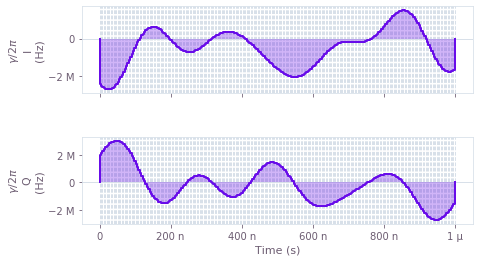

In [6]:
# Run the optimization
result = run_optimization(dimt, dimc, subspace_target, gate_duration, max_rabi_rate)

print("Cost: " + str(result.cost))
controls["Q-CTRL"] = result.output

plot_controls(plt.figure(), controls["Q-CTRL"], polar=False)

The plot above displays the pulses for the optimized SNAP gate. The maximum Rabi rate and cutoff frequency of these controls is set sufficiently high to ensure that all of the populated cavity levels can be simultaneously addressed.

### State leakage analysis using simulation

Here you'll simulate the evolution of the system under the optimized SNAP gate, using the same initial state as before.

In [7]:
# simulation space

sim_dimt = 2  # transmon dimensions
sim_dimc = 4  # Higher cavity dimensions

c_initial_state = np.full((sim_dimc), 1)
c_initial_state = c_initial_state / np.sqrt(
    np.abs(c_initial_state.dot(np.conj(c_initial_state)))
)
t_initial_state = np.zeros(sim_dimt)
t_initial_state[0] = 1
initial_state = np.kron([t_initial_state], [c_initial_state])

sample_points = 512

# simulate
simulation_results["Q-CTRL"] = simulate_unitaries(
    sim_dimt, sim_dimc, controls["Q-CTRL"], sample_points
)

100%|██████████| 100/100 [00:08<00:00, 11.16it/s]


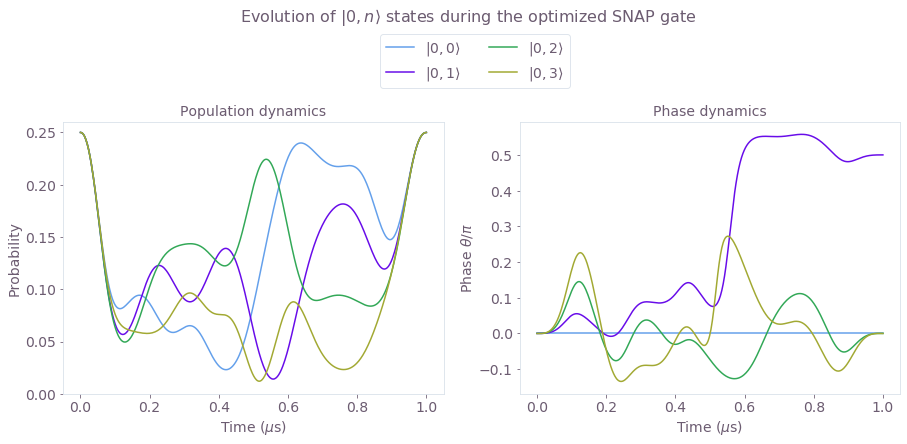

In [8]:
# Plot the state evolutions
simulation_result = simulation_results["Q-CTRL"].samples
sample_times = []
populations = []
phases = []
transmon_pops = []

for step in simulation_result:
    evolved_state = step.evolution_operator.dot(initial_state.T)
    sample_times.append(step.time)
    populations.append([])
    phases.append([])
    for n in range(sim_dimc):
        cavityn = np.zeros(sim_dimc)
        cavityn[n] = 1.0
        population = (
            np.abs(np.sum(np.kron(np.diag([1, 0]), [cavityn]).dot(evolved_state))) ** 2
        )
        populations[-1].append(population)
        phase = np.angle(
            np.sum(np.kron(np.diag([1.0, 0.0]), [cavityn]).dot(evolved_state))
        )
        phases[-1].append(phase)

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(3 * 5)
fig.suptitle(
    r"Evolution of $|0,n\rangle$ states during the optimized SNAP gate",
    fontsize=16,
    y=1.2,
)
gs = gridspec.GridSpec(1, 2)
# plot probabilities
ax = fig.add_subplot(gs[0])
ax.set_xlabel(r"Time ($\mu$s)", fontsize=14)
ax.set_ylabel(r"Probability", fontsize=14)
ax.set_title(r"Population dynamics", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_ylim([0, 0.26])
for n in range(sim_dimc):
    ax.plot(
        np.array(sample_times) / 1e-6,
        np.array(populations).T[n],
        label=n,
        color=colors_qctrl[n],
    )
# plot phases
ax = fig.add_subplot(gs[1])
ax.set_xlabel(r"Time ($\mu$s)", fontsize=14)
ax.set_ylabel(r"Phase $\theta/\pi$", fontsize=14)
ax.set_title(r"Phase dynamics", fontsize=14)
ax.tick_params(labelsize=14)
for n in range(sim_dimc):
    ax.plot(
        np.array(sample_times) / 1e-6,
        (np.array(phases).T[n] - np.array(phases).T[0]) / np.pi,
        label=r"$|0,%i\rangle$" % (n),
        color=colors_qctrl[n],
    )

plt.legend(ncol=2, loc="best", bbox_to_anchor=(0.15, 1.35), fontsize=14)

plt.show()

Plotted are the populations (left) and relative phases (right) of the $|0,n\rangle$ states during the optimized SNAP gate. The control solution you generated using BOULDER OPAL is shorter than the standard gate because it allowed you to leveraged a higher Rabi rate. The impact of leakage is actively controlled throughout the gate ensuring the neighboring Fock states populations follow their individual trajectories back to the original starting point. Observe that the relative phases of the states evolve in such a way that the phase of the targeted $|1\rangle_C$ state reaches the specified target value $\theta =\pi/2$ by the end of the gate, while phases of the neighboring states converge to 0, in the process also eliminating the effects of the Kerr term.